# INTRODUCTION

In this article, I will explain and implement the well known Traveling Salesman Problem aka TSP with special focus on subtour elimination methods. We will use python to implement the  MILP formulation.The dataset contains the coordinates of various cities of India. The aim is to find a shortest path that cover all cities. We will cover the  following things in the article


1. **Input the data and visualize the problem**<br/><br/>
2. **Model TSP as MILP formulation w/o Subtour contraints**<br/><br/>
3. **Implement Subtour Elimination Method 1: MTZ's Approach**<br/><br/>

4. **Implement Subtour Elimination Method 2: DFJ's Approach**<br/><br/>
5. **Compare  MTZ's formulation and DFJ's formulation**<br/><br/>
6. **Conclusion**<br/><br/>



# 1 Input the data and  problem visualization

The csv file *"tsp_city_data.csv"* contains the names of cities in India with thier latitute and longitute information. The first city *"Delhi"* is assumed to be starting point of trip (depot). The data input to TSP model is the distance matrix which stores the distance (or travel time or cost) from each city (location) to every other city. Thus, for a traveling salesman problem for *N* cities (location), the distance matrix is of size *N x N*.
The varible * no_of_locs* in the code is used to define the first n no. of cities we want to include in our TSP problem data. The value is set 20 for now.  The pyhton *pandas* library is used to read csv file and distance matrix "*dis_mat*".

In [4]:
!pip install pandas
!pip install scipy
!pip install matplotlib

In [1]:
!pip install pulp

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 69.0 MB/s eta 0:00:00


In [6]:
#import libraries
%matplotlib inline
import pulp
import pandas as pd
from scipy.spatial import distance_matrix
from matplotlib import pyplot as plt
import time
import copy

In [7]:
#This function takes locations as input and plot a scatter plot
def plot_fig(loc,heading="plot"):

    plt.figure(figsize=(10,10))
    for i,row in loc.iterrows():
        if i==0:
            plt.scatter(row["x"],row["y"],c='r')
            plt.text(row["x"]+0.2, row["y"]+0.2, 'DELHI (depot) ')
        else:
            plt.scatter(row["x"], row["y"], c='black')
            plt.text(row["x"] + 0.2, row["y"] + 0.2,full_data.loc[i]['CITy'] )
        plt.ylim(6,36)
        plt.xlim(66,96)
        plt.title(heading)
# this function takes route plan as input and return the ordered routes and subtours, if present
def get_plan(r0):
    r=copy.copy(r0)
    route = []
    while len(r) != 0:
        plan = [r[0]]
        del (r[0])
        l = 0
        while len(plan) > l:
            l = len(plan)
            for i, j in enumerate(r):
                if plan[-1][1] == j[0]:
                    plan.append(j)
                    del (r[i])
        route.append(plan)
    return(route)


----------data--------------
       CITy        x        y
0     Delhi  77.2300  28.6600
1    Rājkot  70.7984  22.2969
2    Nāgpur  79.0831  21.1539
3   Kolkāta  88.3378  22.5411
4  Agartala  91.2667  23.8333
5    Dispur  91.7700  26.1500
-----------------------------


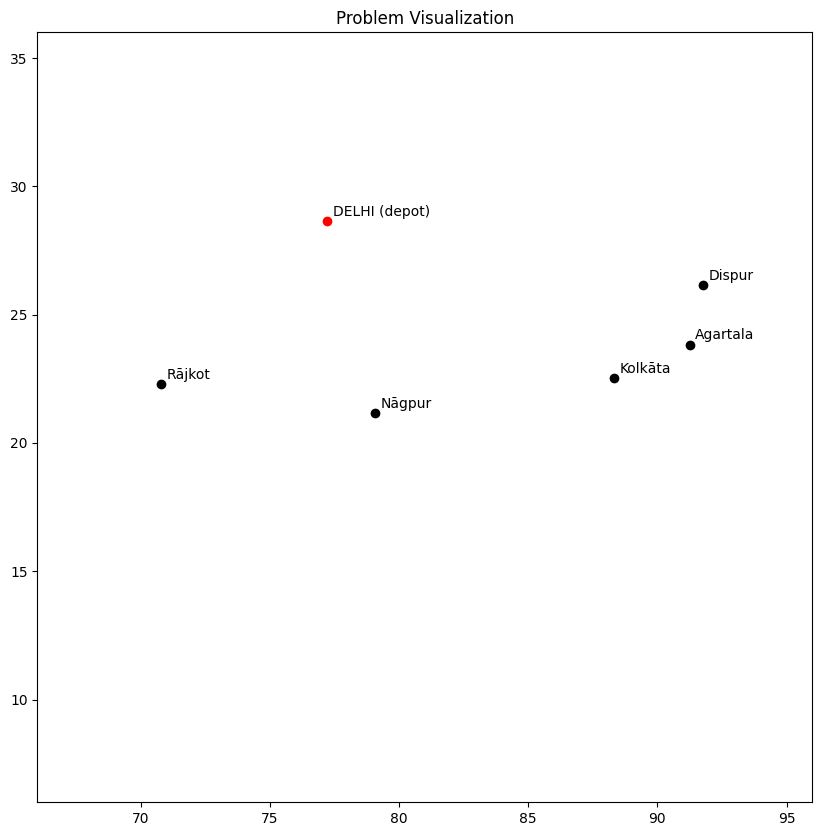

In [8]:
# set no of cities
no_of_locs=6
data=pd.read_csv("tsp_city_data.csv")
full_data=data.iloc[0:no_of_locs,:]
d=full_data[['x','y']]
dis_mat=pd.DataFrame(distance_matrix(d.values,d.values),\
                       index=d.index,columns=d.index)
print("----------data--------------")
print(full_data)
print("-----------------------------")
plot_fig(d,heading="Problem Visualization")

plt.show()


# 2 Model TSP in  MILP  without Subtour elimination constraints

TSP problem can be modeled as Mixed Integer Linear Program. The LP Model is exlained as follows<Br\><Br\>
**Data** <Br\><Br\>
N= Number of location including depot (starting point) <Br\>
$C_{i,j}$ = Edge cost from node i to node j  where i,j= [1...N]<Br\><BR\>
**Decision Variable**<Br\> <Br\>
$x_{i,j}$ = 1 if solution has direct path from node i to j, otherwise 0 <Br\>


The LP model is formilated as follows<Br\>

### MIN          $C_{i,j}$  $x_{i,j} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;(1)$
s.t <Br\><Br\>
$\sum_{j=1}^{N} x_{i,j} = 1 \;\;\;\;\;\;\;\;\;  i ={1...N} \;\;\;\;\;\;\;\;\; (2)$<Br\> <Br\>
$\sum_{i=1}^{N} x_{i,j} = 1  \;\;\;\;\;\;\;\;\; j ={1...N} \;\;\;\;\;\;\;\;\; (3)$<Br\> <Br\>
$ x_{i,i} = 0  \;\;\;\;\;\;\;\;\; i ={1...N} \;\;\;\;\;\;\;\;\; (4)$<Br\> <Br\>

The objective (1) minimize the cost of tour. Constraints (2) and (3) ensures that for each node, there is only one outflow and inflow edge respectively. Thus, ach node is visited only once. Constraint (3) restrict outflow to one's own node.



In this article, python PuLP library is used for implementing MILP model in python. PuLP is an LP modeler written in Python. PuLP can call variety of LP solvers like CBC, CPLEX, GUROBI, SCIP to solve linear problems.It can be installed from the link https://pypi.org/project/PuLP/. The CBC solver is preinstalled in the PuLP library while one  has to install other solvers like gurobi, cplex  separately to use in PuLP. In this implementation CBC is used as LP solver.
<br/><br/>



In [ ]:
model=pulp.LpProblem('tsp',pulp.LpMinimize)
#define variable
x=pulp.LpVariable.dicts("x",((i,j) for i in range(no_of_locs) \
                             for j in range(no_of_locs)),\
                            cat='Binary')

#set objective
model+=pulp.lpSum(dis_mat[i][j]* x[i,j] for i in range(no_of_locs) \
                      for j in range(no_of_locs))
# st constraints
for i in range(no_of_locs):
    model+=x[i,i]==0
    model+=pulp.lpSum(x[i,j] for j in range(no_of_locs))==1
    model += pulp.lpSum(x[j, i] for j in range(no_of_locs)) == 1

status=model.solve()
#status=model.solver()
print("-----------------")
print(status,pulp.LpStatus[status],pulp.value(model.objective))
route=[(i,j) for i in range(no_of_locs) \
           for j in range(no_of_locs) if pulp.value(x[i,j])==1]

print(get_plan(route))
print(route)

-----------------
1 Optimal 35.694391065563096
[[(0, 2), (2, 1), (1, 0)], [(3, 5), (5, 4), (4, 3)]]
[(0, 2), (1, 0), (2, 1), (3, 5), (4, 3), (5, 4)]


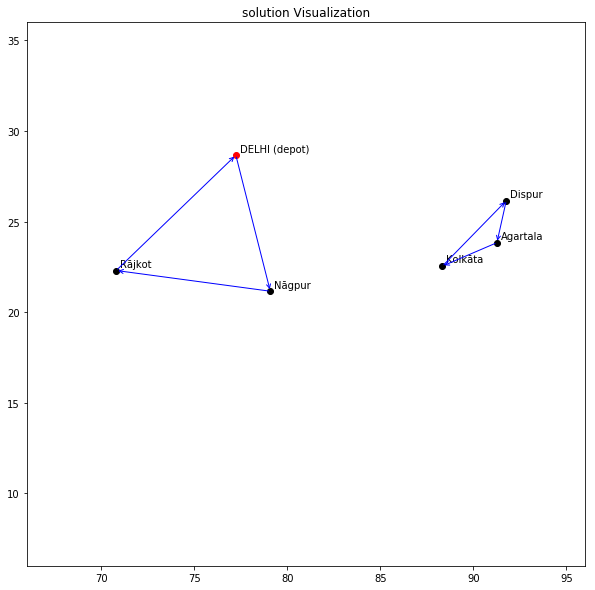

In [ ]:

plot_fig(d,heading="solution Visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in route:
    plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                      xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                     arrowprops=arrowprops)

![image info](https://github.com/my612/TSP-ILP/blob/main/not_expected.jpg?raw=1)

The optimal solution given by the LP model has subtours i.e <BR\>
1. **Tour 1 :** Delhi > Nagpur > Rajkot
2. **Tour 2 :** Kolkata > Dispur > Agartala

The solution given by th model has 2 tours but what required is the singlt tour that starts with depot (Delhi) and visit all locations one by one and ends at Delhi. To solve this problem and to get desired single tour, the sobtour elimination constraints need to be added in the LP Model. <Br\>

There are 2 well known formualtions DSF and MTZ (named after their authors). This atile cover both the ideas and the implementation in python.



# 3. MTZ Method for subtour elimination
This formulation was proposed by Miller, Tucker, Zemlin. To eliminate subtours, decision variables representing times at which a location is visited is added. Variable for all locations except depot node are added.
$t_{i}$ = time at which location i is visited , i =[2,...N]
Finally what is required the constraint <Br\><Br\>
$ t_{j}$ > $t_{i} \;\;\;\;\;\;\;\; if \;\;x_{i,j} =1$
which can be formulated as LP constraints as follows <Br\>

$t_{j} \geq t_{i} - B(1-x_{i,j})  \;\;\;\;\;\;\;\;\;\;\;\;\; (5)\;\;\;\;\;$
for some large value of B

### How does constraint (5) remove subtours ?
Lets takes an previous example and take the subtour Kolkata (k) > Dispur(d) > Agartala(a) <Br\>
so, $x_{k,d}=1$, $x_{d,a}=1$, $x_{a,k}=1$
Now as per constraint (5)

$t_{d} > t_{k}\;\;\;\;\;\;\;\;\;\;\;\;\; (6)$, <Br\>
$t_{a} >  t_{d}\;\;\;\;\;\;\;\;\;\;\;\;\; (7)$, <Br\>
$t_{k} > t_{a}\;\;\;\;\;\;\;\;\;\;\;\;\; (8)$ <Br\>
from (6) and (7) $\;\;\;t_{a} > t_{k}$ but as per constraint (8) $\;\;\;\;t_{k} > t_{a}$  which is not possible.<Br\>
**So adding constraint (5) will eliminate the sobtour.**

The complete Lp model is formulated as follows <Br\><Br\>
**Data** <Br\><Br\>
N= Number of location including depot (starting point) <Br\>
$C_{i,j}$ = Edge cost from node i to node j  where i,j= [1...N]<Br\><BR\>
**Decision Variable**<Br\> <Br\>
$x_{i,j}$ = 1 if solution has direct path from node i to j, otherwise 0 <Br\>
$t_{i}$ = time at which location i is visited , i =[2,...N]


The LP model is formilated as follows<Br\>

### MIN          $C_{i,j}$  $x_{i,j} \;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;\;(9)$
s.t <Br\><Br\>
$\sum_{j=1}^{N} x_{i,j} = 1 \;\;\;\;\;\;\;\;\;  i ={1...N} \;\;\;\;\;\;\;\;\; (10)$<Br\> <Br\>
$\sum_{i=1}^{N} x_{i,j} = 1  \;\;\;\;\;\;\;\;\; j ={1...N} \;\;\;\;\;\;\;\;\; (11)$<Br\> <Br\>
$ x_{i,i} = 0  \;\;\;\;\;\;\;\;\; i ={1...N} \;\;\;\;\;\;\;\;\; (12)$<Br\> <Br\>
$t_{j} \geq t_{i} - B(1-x_{i,j}) \;\;\;\;\;i,j=[2,....N] \;\;\;\;\;\;\;\;\;\;\;\;\; (13)$ <Br\><Br\>
$x_{i,j}=\{0,1\}$ , $\;\;\; t_{i}=[1,...N-1]\;\;\;\;\;\;\;\;\;(14) $












-----------------
1 Optimal 47.09569513410826
[(0, 5), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4)]
time taken by MTZ formulation =  0.12282586097717285


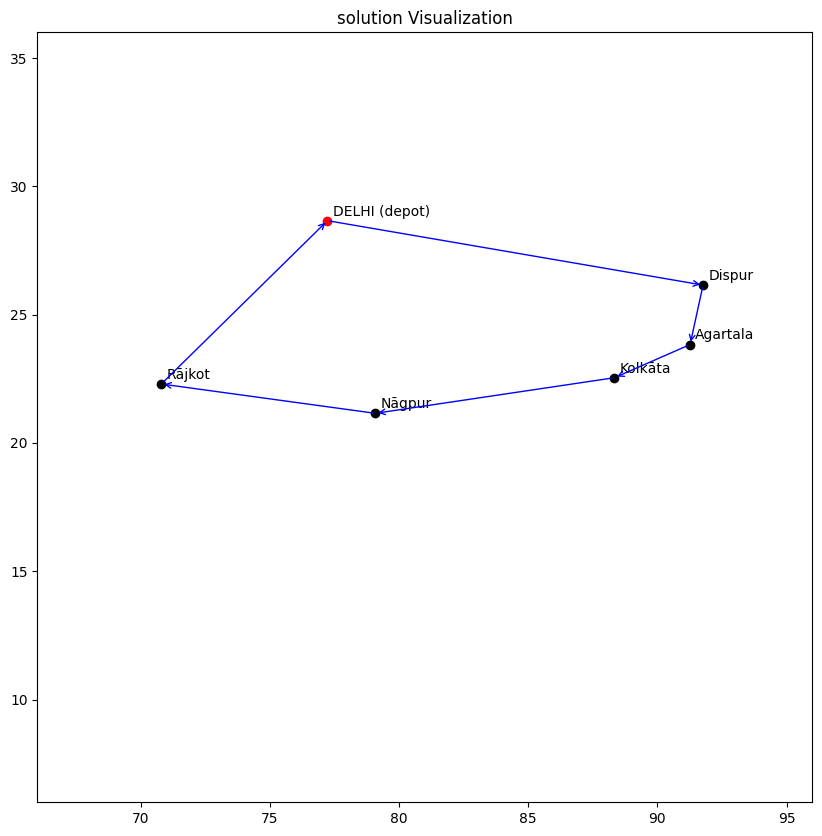

In [11]:
start_t=time.time()
model=pulp.LpProblem('tsp',pulp.LpMinimize)
#define variable
x=pulp.LpVariable.dicts("x",((i,j) for i in range(no_of_locs) \
                                for j in range(no_of_locs)),\
                           cat='Binary')

t = pulp.LpVariable.dicts("t", (i for i in range(no_of_locs)), \
                             lowBound=0,upBound= no_of_locs -1, cat='Integer')
#set objective
model+=pulp.lpSum(dis_mat[i][j]* x[i,j] for i in range(no_of_locs) \
                      for j in range(no_of_locs))
# st constraints
for i in range(no_of_locs):
    model+=x[i,i]==0
    model+=pulp.lpSum(x[i,j] for j in range(no_of_locs))==1
    model += pulp.lpSum(x[j, i] for j in range(no_of_locs)) == 1
#eliminate subtour
for i in range(no_of_locs):
    for j in range(no_of_locs):
        if i!=j and (i!=0 and j!=0):
            model+=t[j]+1>=t[i]+2 - (2*no_of_locs)*(1-x[i,j])
status=model.solve()
#status=model.solver()
model.writeLP("tsp.lp")
print("-----------------")
print(status,pulp.LpStatus[status],pulp.value(model.objective))
route=[(i,j) for i in range(no_of_locs) \
           for j in range(no_of_locs) if pulp.value(x[i,j])==1]
print(route)
plot_fig(d,heading="solution Visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in route:
    plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                      xytext=[d.iloc[i]['x'], d.iloc[i]['y']],\
                     arrowprops=arrowprops)
print("time taken by MTZ formulation = ", time.time()-start_t)

![image info](https://github.com/my612/TSP-ILP/blob/main/1.jpeg?raw=1)

![image_info](https://github.com/my612/TSP-ILP/blob/main/wait.jpeg?raw=1)

# 4. DFJ Method for subtour elimination
This formulation was proposed by  Dantzig, Fulkerson,Jhonson.To eliminate subtours, for every ser **S** of cities , add a constraint saying that the tour leaves **S** atleast once. <Br\><Br\>
$\sum_{i\in S} \sum_{j\notin S}\;\; x_{i,j}>=1\;\;\;\;\;\;\;\; S \subseteq \{1,2,....n\} ,\;\;\; 1 \leq |S| \geq N-1   \;\;\;\;\;\;(15)$<Br\><Br\>

## How does this constraint eliminate subtours?
Lets takes an same example and take a set $S_{i}$= {kolkata, Dispur, Agartala} and the rest of the cities be represented by $s_{i}^{'}$={ Delhi(del),Rajkot(r), Nagpur(n)}<Br\>
Now as per constraint (15), the new constraint added is as follows <Br\>
$ \sum_{i \in s_{i}^{'}} x_{kolkata,i} \sum_{i \in s_{i}^{'}} x_{Dispur,i}\sum_{i \in s_{i}^{'}} x_{Agartala,i} \geq 1\;\;\;\;\;\;\;\;\;\; (16)$ <Br\>
Since there is no edge going to any other node is this set (due to subtour), this equation is not satisfied for the the set $S_{i}$= {{kolkata, Dispur, Agartala}. So, by adding constraint (15), this solution becomes infeasible and all subtours will be eliminated.

## Modification in DFJ Method

For *N* cities,the nunber of posssible sets add up to $ 2^n$ i.e the number of constraints grow exponetially. So, Instead of adding constraints for all the possible sets, only some constraints are added. Given a solution to LP model(without having subtour elimination constraints) with subtours, one can quickly find the subset for which subtour DFS subtour constraint is eliminated. In the example above, one needs to add only 2 constraints and not $2^5$ constraints.<Br\><Br\>

$ \sum_{i \in s_{i}^{'}} x_{kolkata,i} \sum_{i \in s_{i}^{'}} x_{Dispur,i}\sum_{i \in s_{i}^{'}} x_{Agartala,i} \geq 1\;\;\;\;\;\;\;\;\;\; (17)$ <Br\><Br\>
$ \sum_{i \in s_{i}^{'}} x_{Delhi,i} \sum_{i \in s_{i}^{'}} x_{Rajkot,i}\sum_{i \in s_{i}^{'}} x_{Nagpur,i} \geq 1\;\;\;\;\;\;\;\;\;\; (18)$ <Br\><Br\>
These constraints can also be written as<Br\><Br\>
$ x_{kolkata,Dispur}+x_{Dispur,Agartala} +x_{agartala,kolkata} \leq 2 \;\;\;\;\;\;\;(19)$<Br\>
$ x_{Dispur,kolkata}+x_{kolkata,agartala}+x_{Agartala,Dispur}  \leq 2 \;\;\;\;\;\;\;(20)$<Br\>
$ x_{Delhi,Rajkot}+x_{Rajkot,Nagpur} +x_{Nagpur,Delhi} \leq 2 \;\;\;\;\;\;\;(21)$<Br\>
$ x_{Rajkot,Delhi}+x_{Delhi,Nagpur} +x_{Nagpur,Rajkot} \leq 2 \;\;\;\;\;\;\;(22)$<Br\>





So, the higer level algorithm is as follows<Br\>
### Higher level Algorithm for DFS
step 1. Solve TSP problem with LP formulation w/o Subtour Constraints<Br\><Br\>
step 2. If no subtour present in the current solution, goto step 6<Br\><Br\>
step 3. Add subtour constraint **only** for the subtours present in current solution.<Br\><Br\>
step 4. Solve TSP problem with newly added constraint.<Br\><Br\>
step 5. goto step 2<Br\><Br\>
step 6. Return the final TSP solution<Br\><Br\>



-----------------
1 Optimal 47.095695134108254
[[(0, 1), (1, 2), (2, 3), (3, 4), (4, 5), (5, 0)]]
no. of times LP model is solved =  3
subtour log (no. of subtours in each solution)) [2, 3, 1]
Time taken by DFS formulation =  0.1761176586151123


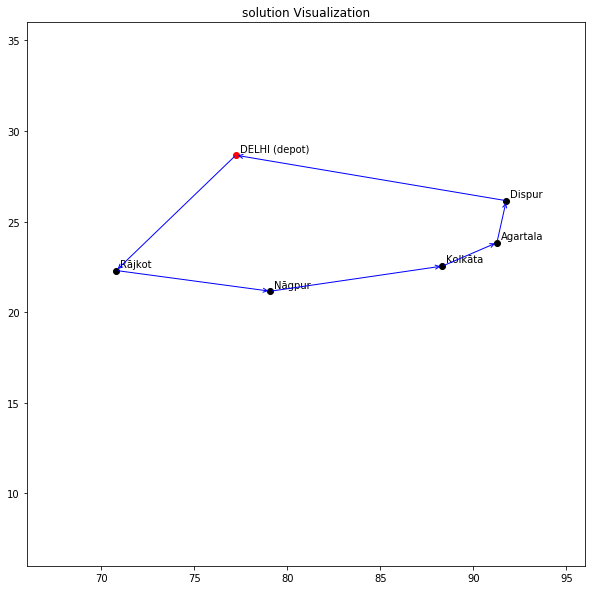

In [ ]:
start_t_1=time.time()
model=pulp.LpProblem('tsp',pulp.LpMinimize)
#define variable
x=pulp.LpVariable.dicts("x",((i,j) for i in range(no_of_locs) \
                                for j in range(no_of_locs)),\
                           cat='Binary')


#set objective
model+=pulp.lpSum(dis_mat[i][j]* x[i,j] for i in range(no_of_locs) \
                      for j in range(no_of_locs))
# st constraints
for i in range(no_of_locs):
    model+=x[i,i]==0
    model+=pulp.lpSum(x[i,j] for j in range(no_of_locs))==1
    model += pulp.lpSum(x[j, i] for j in range(no_of_locs)) == 1

status=model.solve()


route=[(i,j) for i in range(no_of_locs) \
           for j in range(no_of_locs) if pulp.value(x[i,j])==1]
route_plan=get_plan(route)
subtour=[]
while len(route_plan)!=1:
    for i in range(len(route_plan)):
            #print(route_plan[i])

        model+=pulp.lpSum(x[route_plan[i][j][0],route_plan[i][j][1]]\
                              for j in range(len(route_plan[i])))<=\
                              len(route_plan[i])-1
    status=model.solve()
    route = [(i, j) for i in range(no_of_locs) \
                 for j in range(no_of_locs) if pulp.value(x[i, j]) == 1]

    route_plan = get_plan(route)

    subtour.append(len(route_plan))
print("-----------------")
print(status,pulp.LpStatus[status],pulp.value(model.objective))
print(route_plan)
print("no. of times LP model is solved = ",len(subtour))
print("subtour log (no. of subtours in each solution))",subtour)
print("Time taken by DFS formulation = ", time.time()-start_t_1)
plot_fig(d,heading="solution Visualization")
arrowprops = dict(arrowstyle='->', connectionstyle='arc3', edgecolor='blue')
for i, j in route_plan[0]:
    plt.annotate('', xy=[d.iloc[j]['x'], d.iloc[j]['y']],\
                     xytext=[d.iloc[i]['x'], d.iloc[i]['y']],
                     arrowprops=arrowprops)
plt.show()

#print("total time = ",time.time()-start)




# Compare MTZ's Formulation vs DFJ's formulation
Since two approaches for subtour elimination have been discussed in the this articel, its time to compare the two.
MTZ's approach introduces $n^2$ constraints  (one for each pair (i,j) where i,j=[1..n]) while DFJ's apporach introduce subtour constraints for all possible sets of locations i.e $2^n$ for n locations. Thus, MTZ's apporach adds polynomial number of constraints while DFJ's approach introduce exponential number of constraints.<Br\> <BR\>

In terms of decision variables, MTZ approach introduces *n* new decision variables ($t_{i}$ for i =[1..n]).ON the other hand, DFS introduces no new decision variable. MTZ's approach has to be solved only once to get an optimal solution While DFJ is generally implemented as modified version and it is solved iterativey ( i.e LP model has to be solved multiple times with new subtour constraints added every time).<Br\><Br\>

There is no clear winner among the two and for some problems DFJ gives solution faster than MTZ  and for some problems MTZ is faster. But When DHJ has an efficient branch and bound approach due to which it become more efficient than MTZ. Also, MTZ’s formulation is weakeri.e the feasible region has the same integer points, but includes more fractional points.






# Conclusion

In this article, ILP formulation of TSP is explained with special focus on subtour elimination approaches. TSP problem is a special case of Vehicle Routing Problem (VRP) with no. of vehicle equal to 1. But, subtour elimination is a core issue in VRP as well which is solved by using same techniques.